In [1]:
#import needed libraries

#basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#processing, input, output libraries
import rioxarray as rxr
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
from shapely.geometry import mapping
from shapely.geometry import box
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from raster2xyz.raster2xyz import Raster2xyz

#mapping library
from mpl_toolkits.basemap import Basemap

In [2]:
#sets directories

data_dir = "../data"

tif_path = os.path.join(data_dir, "odiac2019_1km_excl_intl_1812.tif")
tif_path_im = rxr.open_rasterio("../data/odiac2019_1km_excl_intl_1812.tif", masked=True).squeeze()

ph_shape = os.path.join(data_dir, "shp", "Country.shp")

In [3]:
# opens the crop shape of the Philippines

crop_extent = gpd.read_file(ph_shape)

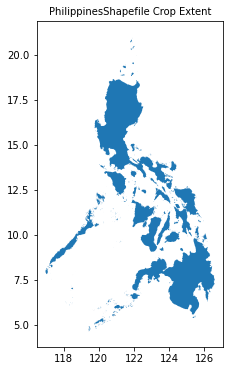

In [4]:
# Plot the crop boundary layer to make sure it's working

fig, ax = plt.subplots(figsize=(6, 6))
crop_extent.plot(ax=ax)
ax.set_title("PhilippinesShapefile Crop Extent", fontsize=10)
plt.show()

In [ ]:
odiac_clipped = tif_path_im.rio.clip(crop_extent.geometry.apply(mapping), crop_extent.crs)

In [ ]:
path_to_tif_file = os.path.join(data_dir, "odiac2019_1km_ph_cropped.tif")

# Write the data to a new geotiff file
odiac_clipped.rio.to_raster(path_to_tif_file)

In [ ]:
# Input raster
input_raster = os.path.join(data_dir, "odiac2019_1km_ph_cropped.tif")

# Output raster
out_tif = os.path.join(data_dir, "geotiff_output.tif")

In [ ]:
# Read the data
data = rasterio.open(input_raster)

In [ ]:
# Visualize
show((data, 1), cmap='terrain')

In [ ]:
# Coordinates
minx, miny = 116.5, 5
maxx, maxy = 127, 20
bbox = box(minx, miny, maxx, maxy)

In [ ]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
print(geo)

In [ ]:
# Project the Polygon into same CRS as the grid
geo = geo.to_crs(crs=data.crs.data)

# Print crs
geo.crs

In [ ]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [ ]:
coords = getFeatures(geo)
print(coords)

In [ ]:
# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

In [ ]:
# Copy the metadata
out_meta = data.meta.copy()

In [ ]:
# Parse EPSG code
epsg_code = int(data.crs.data['init'][5:])

In [ ]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()
                })

In [ ]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

In [ ]:
# Open the clipped raster file
clipped = rasterio.open(out_tif)

In [ ]:
out_csv = "../data/odiac2019_1km_ph_cropped.csv"

rtxyz = Raster2xyz()
rtxyz.translate(input_raster, out_csv)

In [ ]:
raster_csv = pd.read_csv(out_csv)

raster_csv

In [ ]:
#filters data so only data with emissions greater than 0 are used
raster_csv_filtered = raster_csv[(raster_csv['z'] > 0)]

#resets index so it starts from 0
raster_csv_filtered.reset_index()

In [ ]:
raster_csv_filtered.to_csv(r'../data/PH_CO2_geotiff_cropped_filtered.csv', index = False)

In [ ]:
#closer look at the philippine datapoints

fig = plt.figure(figsize=(20,15))

m = Basemap(projection='mill',
           llcrnrlat = 5,
           urcrnrlat = 20,
           llcrnrlon = 116.5,
           urcrnrlon = 127,
           resolution = 'i')

m.drawcoastlines()

m.drawparallels(np.arange(-90,90,10),labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,1])

sites_lat_y = raster_csv_filtered['y'].tolist()
sites_lon_x = raster_csv_filtered['x'].tolist()

m.scatter(sites_lon_x,sites_lat_y,latlon=True, s=5, marker='o', alpha=1, edgecolor='blue', linewidth=.5, zorder=2)

plt.title('Philippines', fontsize=20)

plt.show()